### **Data Analysis**

Проведем анализ собранных данных. Для воспроизведения, вы также можете скачать их с [гугл диска](https://drive.google.com/file/d/1ci7yB0vAdEm1soj0-qM6eS8TqmfsAjcP/view?usp=sharing). 

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
X_acivations_l1 = pd.read_csv('results/X_acivations_l1.csv')
X_acivations_lmid = pd.read_csv('results/X_acivations_lmid.csv')
X_acivations_llast = pd.read_csv('results/X_acivations_llast.csv')

В данных содержатся вопросы из 6-ти токенов "[SOS] When was {name} born? [EOS]".  Почитстим данные от дублей. 

In [4]:
print(X_acivations_l1.duplicated().sum())
print(X_acivations_lmid.duplicated().sum())
print(X_acivations_llast.duplicated().sum())

X_acivations_l1.drop_duplicates(inplace=True)
X_acivations_lmid.drop_duplicates(inplace=True)
X_acivations_llast.drop_duplicates(inplace=True)

504
504
504


In [5]:
print(X_acivations_l1.shape)
print(X_acivations_lmid.shape)
print(X_acivations_llast.shape)

(4997, 6146)
(4997, 6146)
(4997, 6146)


Всего у нас 1024*6 + 2 столбца. Каждые 1024 — есть кодирование токенов. Проанализируем дубли по столбцам, соотвествующим одному токену в последовательности. 

In [23]:
for i in range(0, 6):
    print(f'Токен {i+1}, активаций-дублей:')
    dupl_cnt = X_acivations_l1.iloc[:, 1024*i:1024*(i+1)-2].duplicated().sum()
    print(f'{dupl_cnt}, процент: {round(dupl_cnt/4997*100, 2)}') 
    

Токен 1, активаций-дублей:
4996, процент: 99.98
Токен 2, активаций-дублей:
4996, процент: 99.98
Токен 3, активаций-дублей:
3952, процент: 79.09
Токен 4, активаций-дублей:
3345, процент: 66.94
Токен 5, активаций-дублей:
3263, процент: 65.3
Токен 6, активаций-дублей:
3570, процент: 71.44


In [24]:
for i in range(0, 6):
    print(f'Токен {i+1}, активаций-дублей:')
    dupl_cnt = X_acivations_lmid.iloc[:, 1024*i:1024*(i+1) - 2].duplicated().sum()
    print(f'{dupl_cnt}, процент: {round(dupl_cnt/4997*100, 2)}') 

Токен 1, активаций-дублей:
4996, процент: 99.98
Токен 2, активаций-дублей:
4994, процент: 99.94
Токен 3, активаций-дублей:
3612, процент: 72.28
Токен 4, активаций-дублей:
1544, процент: 30.9
Токен 5, активаций-дублей:
601, процент: 12.03
Токен 6, активаций-дублей:
248, процент: 4.96


In [25]:
for i in range(0, 6):
    print(f'Токен {i+1}, активаций-дублей:')
    dupl_cnt = X_acivations_llast.iloc[:, 1024*i:1024*(i+1) - 2].duplicated().sum()
    print(f'{dupl_cnt}, процент: {round(dupl_cnt/4997*100, 2)}') 

Токен 1, активаций-дублей:
4996, процент: 99.98
Токен 2, активаций-дублей:
4994, процент: 99.94
Токен 3, активаций-дублей:
3612, процент: 72.28
Токен 4, активаций-дублей:
1544, процент: 30.9
Токен 5, активаций-дублей:
601, процент: 12.03
Токен 6, активаций-дублей:
248, процент: 4.96


Заметим, что: 
- Активации первых токенов (`[SOS] When`) в 99% случаев одинаковы. 
- Активации токена 3 ('was') одинаковы в более чем 70% случаев
- "Перелом" уникальности — токен 4 — начало имени персоны.  

Везде выкинем первый-второй. Остальные — выкидывать не будем, так как нам также важна комбинация токенов. 

In [26]:
X_acivations_l1 = X_acivations_l1.iloc[:, 2049:]
X_acivations_lmid = X_acivations_lmid.iloc[:, 2049:]
X_acivations_llast = X_acivations_llast.iloc[:, 2049:]

Оценим, сколько пропусков по прогнозу в собранных даных. 

In [28]:
for data in [X_acivations_l1, X_acivations_lmid, X_acivations_llast]:
    print(data.isna().sum()[data.isna().sum() != 0])

y_pred    454
dtype: int64
y_pred    454
dtype: int64
y_pred    454
dtype: int64


Модель 454 оставшихся (то есть в 9% людей) раз не спрогнозировала год (или он не был найден паттерном). Таких тоже удалим. 

In [29]:
X_acivations_l1.dropna(inplace=True, subset=['y_pred'])
X_acivations_lmid.dropna(inplace=True, subset=['y_pred'])
X_acivations_llast.dropna(inplace=True, subset=['y_pred'])

In [31]:
X_acivations_l1.shape, X_acivations_lmid.shape, X_acivations_llast.shape

((4543, 4097), (4543, 4097), (4543, 4097))

### **Обучение зондирующих моделей.**

Обратим внимание на размерность пространства признаков. Заметим, что модель сейчас обучать не совсем корректно — высока вероятность переобучения (а если бы признаков было больше, чем объектов — обучать было бы совсем не корректно). 

Размерность сократим при помощи метода главных компонент, так, чтобы доля объясняемой дисперсии была `0.7, 0.8, 0.9, 0.95` соответственно. Посмотрим, сколько компонент для этого нужно. 

In [32]:
y_true = X_acivations_l1['y_actual'] 
y_pred = X_acivations_l1['y_pred']


for data in [X_acivations_l1, X_acivations_llast, X_acivations_lmid]:
    data.drop(['y_actual', 'y_pred'], axis=1, inplace=True)

In [33]:
X_acivations_l1.shape, X_acivations_lmid.shape, X_acivations_llast.shape

((4543, 4095), (4543, 4095), (4543, 4095))

Для корректного оценивания важно, чтобы на каждом слое были выбраны одинаковые индексы при разбиении на train/test. Этого можно достичь, зафиксировав `random_state` в `train_test_split` из `sklearn`.

In [34]:
X_train_l1, X_test_l1, y_train_pred, y_test_pred = train_test_split(X_acivations_l1, y_pred, random_state=42)
X_train_lmid, X_test_lmid = train_test_split(X_acivations_lmid, random_state=42)
X_train_llast, X_test_llast = train_test_split(X_acivations_llast, random_state=42)


assert all(X_train_l1.index == X_train_lmid.index)
assert all(X_train_l1.index == X_train_llast.index)


In [35]:
y_train_act, y_test_act = train_test_split(y_true, random_state=42)

assert all(y_train_pred.index == y_train_act.index)

Поочередно применим PCA.

In [36]:
def get_pca_data(X_train, X_test, n_components=100):
    pca = PCA(n_components=n_components)
   
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print(f'Varince explained: {np.sum(pca.explained_variance_ratio_)} with ({n_components} components)')

    return X_train_pca, X_test_pca

Количество компонент для первого слоя. 

In [37]:
# 0.7
X_train_l1_pca_var7, X_test_l1_pca_var7 = get_pca_data(X_train_l1, X_test_l1, n_components=480)
# 0.8
X_train_l1_pca_var8, X_test_l1_pca_var8 = get_pca_data(X_train_l1, X_test_l1, n_components=700)
# 0.9
X_train_l1_pca_var9, X_test_l1_pca_var9 = get_pca_data(X_train_l1, X_test_l1, n_components=1100)
# 0.95
X_train_l1_pca_var95, X_test_l1_pca_var95 = get_pca_data(X_train_l1, X_test_l1, n_components=1500)

Varince explained: 0.7117101593142575 with (480 components)
Varince explained: 0.8029339429541534 with (700 components)
Varince explained: 0.9023904210689495 with (1100 components)
Varince explained: 0.9546721072827444 with (1500 components)


Чтобы достичь разного уровня объясненной дисперсии  на первом слое, необходимо компонент:
- для объясненной дисперсии 0.7 = 480
- для объясненной дисперсии 0.8 = 700
- для объясненной дисперсии 0.9 = 1100
- для объясненной дисперсии 0.95 = 1500

Количество компонент для среднего слоя. 

In [38]:
# 0.7
X_train_lmid_pca_var7, X_test_lmid_pca_var7 = get_pca_data(X_train_lmid, X_test_lmid, n_components=175)
# 0.8
X_train_lmid_pca_var8, X_test_lmid_pca_var8 = get_pca_data(X_train_lmid, X_test_lmid, n_components=310)
# 0.9
X_train_lmid_pca_var9, X_test_lmid_pca_var9 = get_pca_data(X_train_lmid, X_test_lmid, n_components=600)
# 0.95
X_train_lmid_pca_var95, X_test_lmid_pca_var95 = get_pca_data(X_train_lmid, X_test_lmid, n_components=930)

Varince explained: 0.7050801922647513 with (175 components)
Varince explained: 0.8058776039367189 with (310 components)
Varince explained: 0.9030891565305463 with (600 components)
Varince explained: 0.9513861913154726 with (930 components)


Чтобы достичь разного уровня объясненной дисперсии на среднем слое, необходимо компонент:
- для объясненной дисперсии 0.7 = 175
- для объясненной дисперсии 0.8 = 310
- для объясненной дисперсии 0.9 = 600
- для объясненной дисперсии 0.95 = 930

Количество компонент для последнего слоя. 

In [39]:
# ~ 0.7
X_train_llast_pca_var7, X_test_llast_pca_var7 = get_pca_data(X_train_llast, X_test_llast, n_components=2)
# ~ 0.8
X_train_llast_pca_var8, X_test_llast_pca_var8 = get_pca_data(X_train_llast, X_test_llast, n_components=4)
# ~ 0.9
X_train_llast_pca_var9, X_test_llast_pca_var9 = get_pca_data(X_train_llast, X_test_llast, n_components=7)
# ~ 0.95
X_train_llast_pca_var95, X_test_llast_pca_var95 = get_pca_data(X_train_llast, X_test_llast, n_components=17)

Varince explained: 0.6756132598848155 with (2 components)
Varince explained: 0.8162784006694298 with (4 components)
Varince explained: 0.9026182577543362 with (7 components)
Varince explained: 0.9500278603509853 with (17 components)


Чтобы достичь разного уровня объясненной дисперсии на среднем слое, необходимо компонент:
- для объясненной дисперсии 0.7 = 2
- для объясненной дисперсии 0.8 = 4
- для объясненной дисперсии 0.9 = 7
- для объясненной дисперсии 0.95 = 17


In [49]:
100 - 17/930*100

98.17204301075269

Чем глубже слой, тем более значимо меньше нам нужно компонент. Причем, скорее всего, где-то в модели есть переломный момент — когда уменьшение количества необхоимых компонент перстает значимо снижаться. Скорее всего, такой момент наступает после среднего слоя (от первого к центральному снижение на 65, 56, 46, 38 процентов для дисперсий 0.7, 0.8, 0.9, 0.95 соответственно, от центрального к последнему на 99, 98.7, 98.8, 98.1 процентов). 

## **Обучение зонда**

Обучим модели на уровне сохраненной дисперсии 0.9. Прогнозировать будем года, спрогнозированные моделью, а не истинные, поскольку модель не всегда дает верный ответ и, кроме того, если его не дает, значит бесполезно искать знания о нём внутри. 

In [51]:
def get_probing_results(model, X_train, X_test, y_train, y_test, params='unknown'):

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mean_absolute_error(predictions, y_test)
    mse = mean_squared_error(predictions, y_test)
    r2 = r2_score(y_test, predictions)

    metrics = [mae, mse, r2]

    print(f'Metrics of experiment with params {params}, n_components {X_test.shape[1]} are: \n')
    print(f'MAE: {metrics[0]}')
    print(f'MSE: {metrics[1]}')
    print(f'R2: {metrics[2]}')

    return model, predictions, metrics

In [95]:
# l1
from sklearn.tree import DecisionTreeRegressor
lr_l1_var7 =LinearRegression()
lr_l1_var8 =  LinearRegression() # LinearRegression()
lr_l1_var9 = LinearRegression()
lr_l1_var95 = LinearRegression()

# _l1_var

lr_l1_var7, pred_l1_var7, metrics_l1_var7 = get_probing_results(lr_l1_var7, X_train_l1_pca_var7, X_test_l1_pca_var7, y_train_pred, y_test_pred, params='First layer, explainde variance ~ 0.7')
lr_l1_var8, pred_l1_var8, metrics_l1_var8 = get_probing_results(lr_l1_var8, X_train_l1_pca_var8, X_test_l1_pca_var8, y_train_pred, y_test_pred, params='First layer, explainde variance ~ 0.8')
lr_l1_var9, pred_l1_var9, metrics_l1_var9 = get_probing_results(lr_l1_var9, X_train_l1_pca_var9, X_test_l1_pca_var9, y_train_pred, y_test_pred, params='First layer, explainde variance ~ 0.9')
lr_l1_var95, pred_l1_var95, metrics_l1_var95 = get_probing_results(lr_l1_var95, X_train_l1_pca_var95, X_test_l1_pca_var95, y_train_pred, y_test_pred, params='First layer, explainde variance ~ 0.95')

Metrics of experiment with params First layer, explainde variance ~ 0.7, n_components 480 are: 

MAE: 17.297853451990363
MSE: 683.7644788043879
R2: 0.11219471647539803
Metrics of experiment with params First layer, explainde variance ~ 0.8, n_components 700 are: 

MAE: 18.051567233928942
MSE: 721.3754691616269
R2: 0.06336030493045097
Metrics of experiment with params First layer, explainde variance ~ 0.9, n_components 1100 are: 

MAE: 19.669277637791136
MSE: 786.2851890695104
R2: -0.02091899601698377
Metrics of experiment with params First layer, explainde variance ~ 0.95, n_components 1500 are: 

MAE: 21.149835812019575
MSE: 874.6913517361727
R2: -0.13570626669948438


В среднем, на первом слое модель ошибается от истины на 19 лет. 

In [219]:
# # l1

# lr_l1_var7 = LinearRegression()
# lr_l1_var8 = LinearRegression()
# lr_l1_var9 = LinearRegression()
# lr_l1_var95 = LinearRegression()

# # _l1_var

# lr_l1_var7, pred_l1_var7, metrics_l1_var7 = get_probing_results(lr_l1_var7, X_train_l1_pca_var7, X_test_l1_pca_var7, y_train_act, y_test_act, params='First layer, explainde variance ~ 0.7')
# lr_l1_var8, pred_l1_var8, metrics_l1_var8 = get_probing_results(lr_l1_var8, X_train_l1_pca_var8, X_test_l1_pca_var8, y_train_act, y_test_act, params='First layer, explainde variance ~ 0.8')
# lr_l1_var9, pred_l1_var9, metrics_l1_var9 = get_probing_results(lr_l1_var9, X_train_l1_pca_var9, X_test_l1_pca_var9, y_train_act, y_test_act, params='First layer, explainde variance ~ 0.9')
# lr_l1_var95, pred_l1_var95, metrics_l1_var95 = get_probing_results(lr_l1_var95, X_train_l1_pca_var95, X_test_l1_pca_var95, y_train_act, y_test_act, params='First layer, explainde variance ~ 0.95')

Для истинных `y` MAE, MSE стабильно хуже. 

In [97]:
# lmid

lr_lmid_var7 = LinearRegression()
lr_lmid_var8 = LinearRegression()
lr_lmid_var9 =  LinearRegression()
lr_lmid_var95 = LinearRegression()

# _lmid_var

lr_lmid_var7, pred_lmid_var7, metrics_lmid_var7 = get_probing_results(lr_lmid_var7, X_train_lmid_pca_var7, X_test_lmid_pca_var7, y_train_pred, y_test_pred, params='Mid layer, explainde variance ~ 0.7')
lr_lmid_var8, pred_lmid_var8, metrics_lmid_var8 = get_probing_results(lr_lmid_var8, X_train_lmid_pca_var8, X_test_lmid_pca_var8, y_train_pred, y_test_pred, params='Mid layer, explainde variance ~ 0.8')
lr_lmid_var9, pred_lmid_var9, metrics_lmid_var9 = get_probing_results(lr_lmid_var9, X_train_lmid_pca_var9, X_test_lmid_pca_var9, y_train_pred, y_test_pred, params='Mid layer, explainde variance ~ 0.9')
lr_lmid_var95, pred_lmid_var95, metrics_lmid_var95 = get_probing_results(lr_lmid_var95, X_train_lmid_pca_var95, X_test_lmid_pca_var95, y_train_pred, y_test_pred, params='Mid layer, explainde variance ~ 0.95')

Metrics of experiment with params Mid layer, explainde variance ~ 0.7, n_components 175 are: 

MAE: 17.135246038670143
MSE: 632.7933489961332
R2: 0.17837604024073028
Metrics of experiment with params Mid layer, explainde variance ~ 0.8, n_components 310 are: 

MAE: 17.179455590534836
MSE: 624.8519446838407
R2: 0.18868722329514476
Metrics of experiment with params Mid layer, explainde variance ~ 0.9, n_components 600 are: 

MAE: 17.642227146798977
MSE: 617.1044122527994
R2: 0.19874668154396136
Metrics of experiment with params Mid layer, explainde variance ~ 0.95, n_components 930 are: 

MAE: 18.709702089120373
MSE: 668.0634516179501
R2: 0.13258105610692883


В среднем, на первом среднем модель ошибается от истины на 17 лет. 

In [221]:
# # lmid

# lr_lmid_var7 = LinearRegression()
# lr_lmid_var8 = LinearRegression()
# lr_lmid_var9 = LinearRegression()
# lr_lmid_var95 = LinearRegression()

# # _lmid_var

# lr_lmid_var7, pred_lmid_var7, metrics_lmid_var7 = get_probing_results(lr_lmid_var7, X_train_lmid_pca_var7, X_test_lmid_pca_var7,y_train_act, y_test_act, params='Mid layer, explainde variance ~ 0.7')
# lr_lmid_var8, pred_lmid_var8, metrics_lmid_var8 = get_probing_results(lr_lmid_var8, X_train_lmid_pca_var8, X_test_lmid_pca_var8, y_train_act, y_test_act, params='Mid layer, explainde variance ~ 0.8')
# lr_lmid_var9, pred_lmid_var9, metrics_lmid_var9 = get_probing_results(lr_lmid_var9, X_train_lmid_pca_var9, X_test_lmid_pca_var9, y_train_act, y_test_act, params='Mid layer, explainde variance ~ 0.9')
# lr_lmid_var95, pred_lmid_var95, metrics_lmid_var95 = get_probing_results(lr_lmid_var95, X_train_lmid_pca_var95, X_test_lmid_pca_var95, y_train_act, y_test_act, params='Mid layer, explainde variance ~ 0.95')

Для истинных `y` MAE, MSE стабильно хуже. 

In [133]:
# llast

lr_llast_var7 = LinearRegression()
lr_llast_var8 = LinearRegression()
lr_llast_var9 = LinearRegression()
lr_llast_var95 = LinearRegression()

# _lmid_var

lr_llast_var7, pred_llast_var7, metrics_llastvar7 = get_probing_results(lr_llast_var7, X_train_llast_pca_var7, X_test_llast_pca_var7, y_train_pred, y_test_pred, params='Last layer, explainde variance ~ 0.7')
lr_llast_var8, pred_llast_var8, metrics_llast_var8 = get_probing_results(lr_llast_var8, X_train_llast_pca_var8, X_test_llast_pca_var8, y_train_pred, y_test_pred, params='Last layer, explainde variance ~ 0.8')
lr_llast_var9, pred_llast_var9, metrics_llast_var9 = get_probing_results(lr_llast_var9, X_train_llast_pca_var9, X_test_llast_pca_var9, y_train_pred, y_test_pred, params='Last layer, explainde variance ~ 0.9')
lr_llast_var95, pred_llast_var95, metrics_llast_var95 = get_probing_results(lr_llast_var95, X_train_llast_pca_var95, X_test_llast_pca_var95, y_train_pred, y_test_pred, params='Last layer, explainde variance ~ 0.95')

Metrics of experiment with params Last layer, explainde variance ~ 0.7, n_components 2 are: 

MAE: 14.677540603294403
MSE: 769.4639636512902
R2: 0.0009218179834264983
Metrics of experiment with params Last layer, explainde variance ~ 0.8, n_components 4 are: 

MAE: 14.672357637475264
MSE: 767.5248981727561
R2: 0.003439516153347366
Metrics of experiment with params Last layer, explainde variance ~ 0.9, n_components 7 are: 

MAE: 14.804458125897948
MSE: 753.6630034662152
R2: 0.021437911421916866
Metrics of experiment with params Last layer, explainde variance ~ 0.95, n_components 17 are: 

MAE: 15.265246150209196
MSE: 741.628232098107
R2: 0.037063955093123324


В среднем, на первом слое модель ошибается от истины на 14 лет. 

In [134]:
# # llast

# lr_llast_var7 = LinearRegression()
# lr_llast_var8 = LinearRegression()
# lr_llast_var9 = LinearRegression()
# lr_llast_var95 = LinearRegression()

# # _lmid_var

# lr_llast_var7, pred_llast_var7, metrics_llastvar7 = get_probing_results(lr_llast_var7, X_train_llast_pca_var7, X_test_llast_pca_var7, y_train_act, y_test_act, params='Last layer, explainde variance ~ 0.7')
# lr_llast_var8, pred_llast_var8, metrics_llast_var8 = get_probing_results(lr_llast_var8, X_train_llast_pca_var8, X_test_llast_pca_var8, y_train_act, y_test_act, params='Last layer, explainde variance ~ 0.8')
# lr_llast_var9, pred_llast_var9, metrics_llast_var9 = get_probing_results(lr_llast_var9, X_train_llast_pca_var9, X_test_llast_pca_var9, y_train_act, y_test_act, params='Last layer, explainde variance ~ 0.9')
# lr_llast_var95, pred_llast_var95, metrics_llast_var95 = get_probing_results(lr_llast_var95, X_train_llast_pca_var95, X_test_llast_pca_var95, y_train_act, y_test_act, params='Last layer, explainde variance ~ 0.95')

Для истинных `y` MAE, MSE стабильно хуже. 

### **Выводы**

Лучшая модель по результату получается на среднем слое. Это позволяет выдвинуть гипотезу о том, что, если в модели отдельно представлена информации, связанныя с числами, то она представлена ближе к центру. Но почему $R^2$ стабильно меньше или около нуля? Посмотрим на прогнозы

# **Анализ прогнозов**

In [135]:
import matplotlib.pyplot as plt

def get_plot(y_preds, y_actual, titles):

    fig, ax = plt.subplots(1, len(y_preds), figsize=(20, 4))

    for i in range(0, len(y_preds)):
        ax[i].scatter(y_preds[i], y_actual)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel('predictions')
        ax[i].set_ylabel('target')

In [136]:
# get_plot([pred_l1_var7, pred_l1_var8, pred_l1_var9, pred_l1_var95], y_test_pred, ['First layer, variance = 0.7\n n_comp=480', 'First layer, variance = 0.8\n n_comp=700', 
#                                                                                   'First layer, variance = 0.9\n n_comp=1100', 'First layer, variance = 0.95\n n_comp=1500'])

In [129]:
# get_plot([pred_lmid_var7, pred_lmid_var8, pred_lmid_var9, pred_lmid_var95], y_test_pred, ['Mid layer, variance = 0.7\n n_comp=175', 'Mid layer, variance = 0.8\n n_comp=310', 
#                                                                                   'Mid layer, variance = 0.9\n n_comp=600', 'Mid layer, variance = 0.95\n n_comp=930'])

In [130]:
# get_plot([pred_llast_var7, pred_llast_var8, pred_llast_var9, pred_llast_var95], y_test_pred, ['Mid layer, variance = 0.7\n n_comp=2', 'Mid layer, variance = 0.8\n n_comp=4', 
#                                                                                   'Mid layer, variance = 0.9\n n_comp=7', 'Mid layer, variance = 0.95\n n_comp=17'])

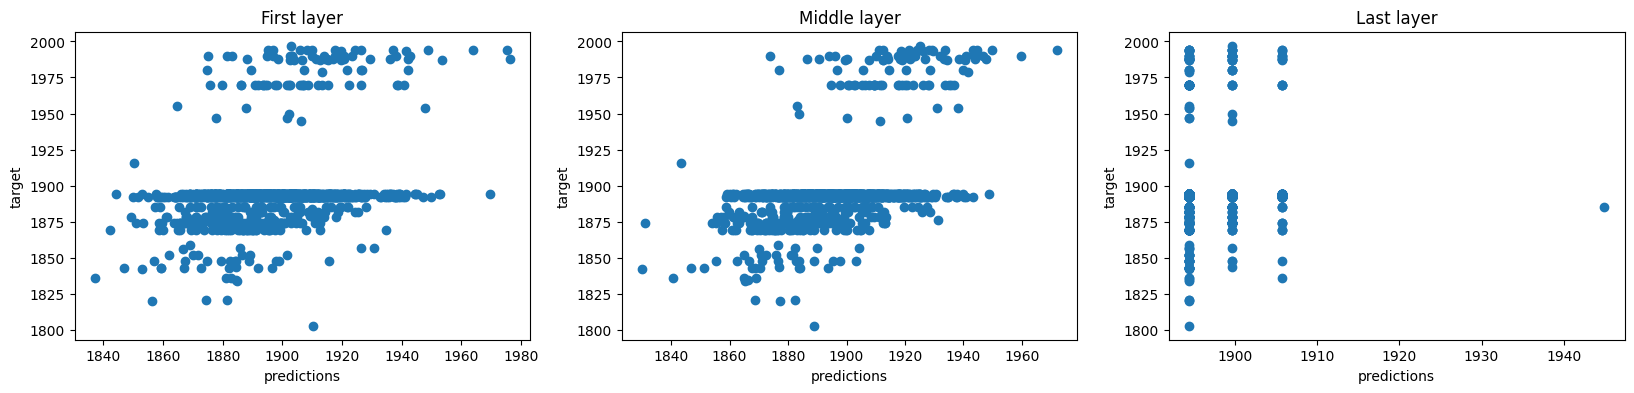

In [131]:
get_plot([pred_l1_var9, pred_lmid_var9, pred_llast_var9], y_test_pred, ['First layer', 'Middle layer', 'Last layer'])

Text(0.5, 1.0, 'y pred last layer (probing results)')

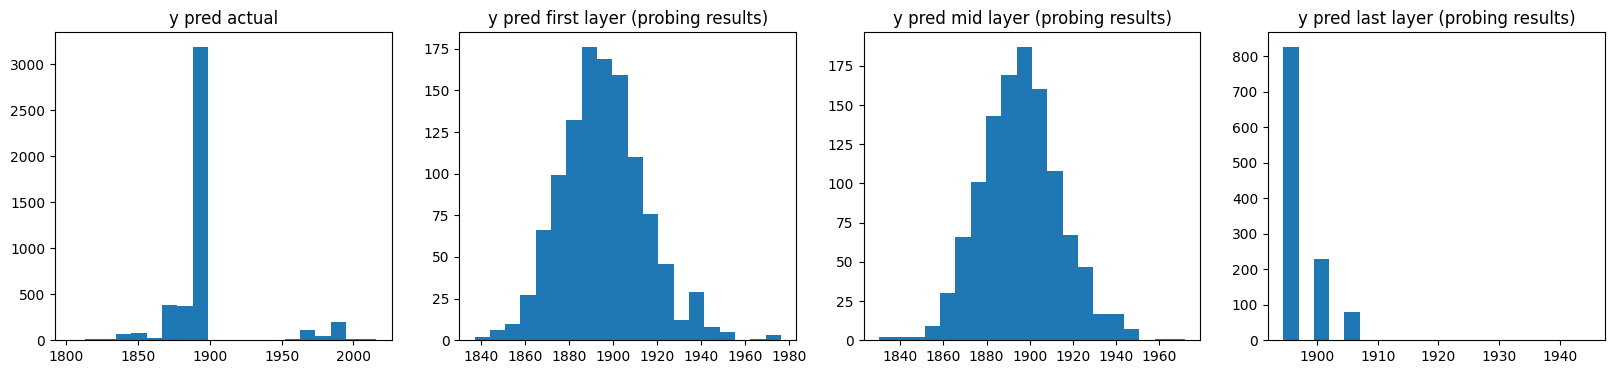

In [132]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

ax[0].hist(y_pred, bins=20)
ax[0].set_title('y pred actual')
ax[1].hist(pred_l1_var9, bins=20);
ax[1].set_title('y pred first layer (probing results)')
ax[2].hist(pred_lmid_var9, bins=20);
ax[2].set_title('y pred mid layer (probing results)')
ax[3].hist(pred_llast_var9, bins=20);
ax[3].set_title('y pred last layer (probing results)')

Прогнозы модели истинной модели кусочны, причем большая часть сконцентрирована около 1860-1900 годов. Прогнозы же линейных моделей похожи на нормальное распределение. Эти факты делают второе слагаемое в $r^2$ большим, так как в целом линейная модель требует нормального распределения целевой переменной. Можно попробовать decision tree. Оно переобучается, но дает картинку лучше. 

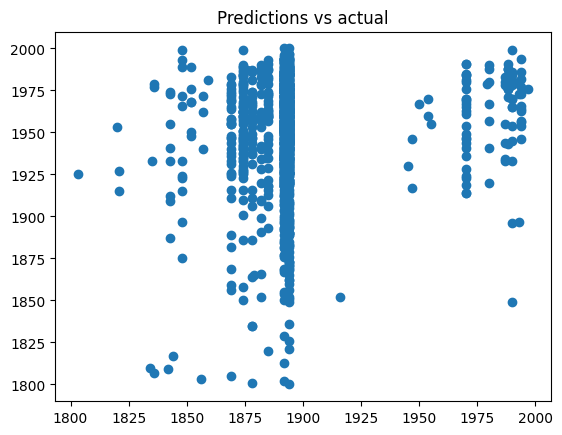

In [112]:
fig, ax = plt.subplots()

ax.scatter(y_test_pred, y_test_act)
ax.set_title('Predictions vs actual');

In [141]:
y_pred[y_pred > 1900], 405/4543*100

(3       1993.0
 11      1970.0
 13      1979.0
 26      1970.0
 28      1988.0
          ...  
 5391    1970.0
 5439    1994.0
 5443    1988.0
 5461    1988.0
 5466    1970.0
 Name: y_pred, Length: 405, dtype: float64,
 8.914813999559762)

Выводы:

Анализ зонда позволил приблизиться к оценке расположения знаний внутри модели. В случае эксперимента в туториале, лучшими оказались средние слои, что не всегда справедливо. Кроме того, сам анализ зондов можно улучшать, например строить не линейную модель (например, дерево) или ограничить анализ прогнозами до 1900 года (так как других прогнозов всего 8.9% от данных). Надеюсь, туториал станет хорошей отправной точкой для вас! 

Благодарю за ваше время! Присоединяйтесь к [каналу в телеграм](https://t.me/jdata_blog), чтобы видеть новые туториалы :) Также приглашаю пройти мой [rурс](https://stepik.org/a/198640) по explainable AI и, конечно, буду рада видеть в сети [LinkedIn](https://www.linkedin.com/in/sabrina-sadiekh-35181a286/).

Успешных вам проектов!
Ваш Дата-автор!